**Problem Statement**: this is a time series dataset collected by a retailer with the goal of forecasting customer demand for its products. As this firm operates on a vast geographical scale, with central warehouses in different regions to facilitate the storage and delivery of a variety of products, being able to estimate the quantity and characteristics of these orders will help the firm improve its service substantially. Specifically, accurate forecasting over multi-horizons will enable the firm to strategically plan for both short-term and long-term demands, reduce cost efficiently and speed up the delivery time, increasing customer satisfaction in overall.

This notebook goes through the EDA on this dataset, bearing the following points in mind:

- **Metric:** since we don't have access to any other quantities but orders, the main metric in this analysis will be average order quantity per order. To be precise, average order quantity = total order quantities / total order counts. We will see how this metric fluctuates through time and by product.  
- **Qualitative dimensions**:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib.colors import Normalize
from google.colab import drive
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/Historical Product Demand.csv')

In [ ]:
df1.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Product_Code      1048575 non-null  object
 1   Warehouse         1048575 non-null  object
 2   Product_Category  1048575 non-null  object
 3   Date              1037336 non-null  object
 4   Order_Demand      1048575 non-null  object
dtypes: object(5)
memory usage: 40.0+ MB


In [ ]:
df1['Date'] = pd.to_datetime(df1['Date'])

In [ ]:
df1['Date'].describe()

,Date
count,1037336
mean,2014-06-17 05:14:07.756175104
min,2011-01-08 00:00:00
25%,2013-04-05 00:00:00
50%,2014-06-10 00:00:00
75%,2015-08-26 00:00:00
max,2017-01-09 00:00:00


In [ ]:
print(df1.shape)
df1.dropna(subset=['Date'],inplace=True)
print(df1.shape)

(1048575, 5)
(1037336, 5)


In [ ]:
df1['month'] = df1.index.month
df1['year'] = df1.index.year

In [ ]:
df1.dtypes

,0
Product_Code,object
Warehouse,object
Product_Category,object
Order_Demand,object
month,int32
year,int32


In [ ]:
def is_convertible_to_numeric(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

In [ ]:
df1['Order'] = df1['Order_Demand'].apply(lambda x: float(x[1:-1]) if not is_convertible_to_numeric(x) else x)

In [ ]:
df1['Order'] = df1['Order'].apply(float)

In [ ]:
count_time = df1.groupby(['year','month'])['Order'].size().reset_index()
norm = Normalize(vmin=min(count_time['Order']), vmax=max(count_time['Order']))
count_time['size'] = (count_time['Order'].apply(norm) + 0.1)*100

In [ ]:
count_time

,year,month,Order,size
0,2011,1,1,10.000000
1,2011,5,1,10.000000
2,2011,6,2,10.004074
3,2011,9,4,10.012222
4,2011,10,3,10.008148
...,...,...,...,...
63,2016,9,15376,72.640049
64,2016,10,16191,75.960481
65,2016,11,17335,80.621308
66,2016,12,15036,71.254838


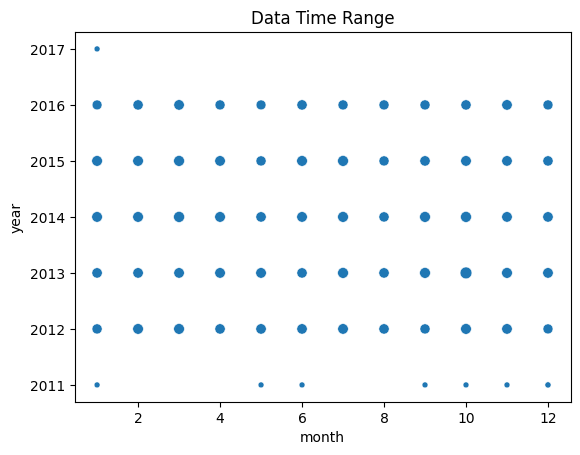

In [ ]:
sns.scatterplot(count_time,x='month',y='year', marker='o',size='size')
plt.legend().set_visible(False)
plt.title('Data Time Range');

In [ ]:
# just keep data from 2012 to 2016
df1 = df1[df1['year'].apply(lambda x: x not in [2011, 2017])]

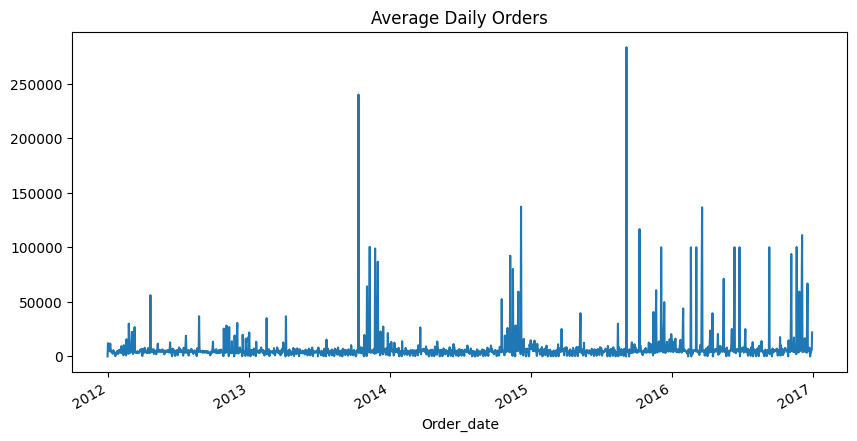

In [ ]:
plt.figure(figsize=(10,5))
df1.sort_values(by='Order_date').groupby('Order_date')['Order'].mean().plot()
# plt.yscale('log')
plt.title('Average Daily Orders');

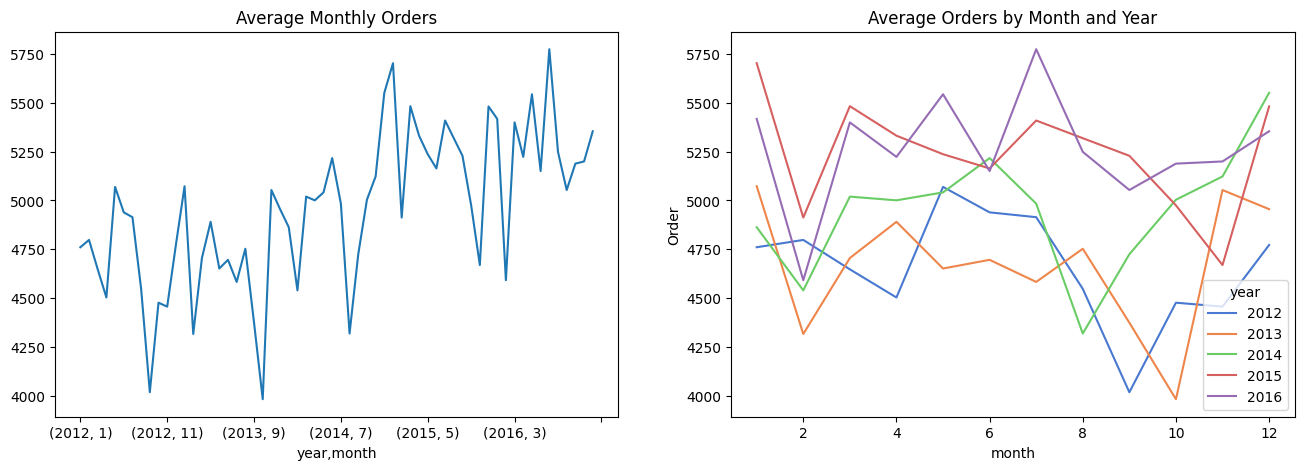

In [ ]:
# plot average order by entire time range and by month, year
mean_orders = df1.sort_values(by='Order_date').groupby(['year','month'])['Order'].mean()
fig, ax = plt.subplots(1,2,figsize=(16,5))
mean_orders.plot(ax=ax[0])
ax[0].set_title('Average Monthly Orders')
sns.lineplot(mean_orders.reset_index(),x='month',y='Order',hue='year',ax=ax[1],palette='muted')
ax[1].set_title('Average Orders by Month and Year');

In [ ]:
def filling(x):
  if x > 0:
    return 'background-color: green'
  elif x < 0:
    return 'background-color: darkred'

In [ ]:
# growth rate compared to same month of previous year - YOY
growth_orders = round(mean_orders.reset_index().pivot_table(index='month',columns='year',values='Order').pct_change(axis=0).fillna(0)*100,3)
growth_orders.style.applymap(filling)

year,2012,2013,2014,2015,2016
month,,,,,
1,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.784000,-14.900000,-6.642000,-13.845000,-15.234000
3,-3.133000,8.998000,10.564000,11.595000,17.578000
4,-3.098000,3.938000,-0.380000,-2.752000,-3.266000
5,12.558000,-4.883000,0.812000,-1.777000,6.133000
6,-2.569000,0.955000,3.482000,-1.392000,-7.088000
7,-0.498000,-2.407000,-4.467000,4.748000,12.101000
8,-7.457000,3.701000,-13.327000,-1.671000,-9.093000
9,-11.629000,-7.955000,9.387000,-1.693000,-3.716000


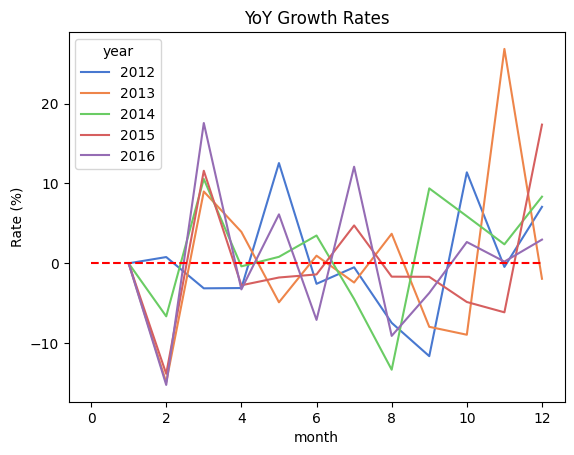

In [ ]:
sns.lineplot(pd.melt(growth_orders.reset_index(),id_vars=['month'],value_name='rate'),x='month',y='rate',hue='year',palette='muted')
plt.hlines(y=0,xmin=0,xmax=12,color='red',linestyle='--')
plt.ylabel('Rate (%)')
plt.title('YoY Growth Rates');

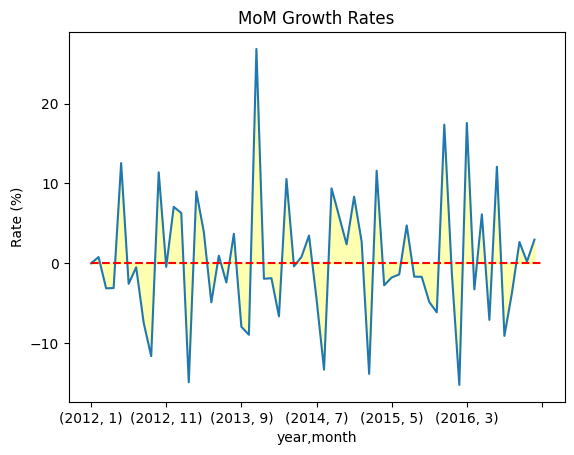

In [ ]:
# growth rate compared to previous month - MoM
fig, ax = plt.subplots()
monthly_growth_orders = mean_orders.pct_change().fillna(0)*100
monthly_growth_orders.plot(ax=ax)
plt.fill_between(ax.get_lines()[0].get_xdata(),monthly_growth_orders.values,alpha=0.3,
                 color='yellow')
plt.hlines(y=0,color='red',xmin=0,xmax=x_.shape[0],linestyle='--')
plt.title('MoM Growth Rates')
plt.ylabel('Rate (%)');

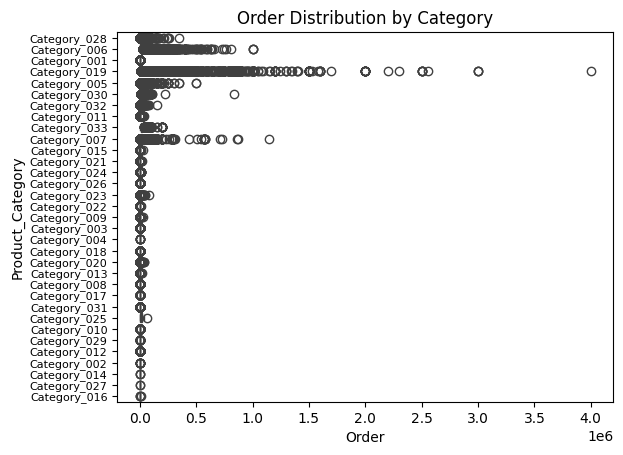

In [ ]:
# Order Distrbution by Product Category
sns.boxplot(df1,x='Order',y='Product_Category',hue='Product_Category')
plt.yticks(fontsize=8)
plt.title('Order Distribution by Category');

In [ ]:
multicat_df = pd.concat([df1.groupby(['Product_Category','Product_Code'])['Order'].sum().rename('sum'),df1.groupby(['Product_Category','Product_Code'])['Order'].size().rename('count'),
           df1.groupby(['Product_Category','Product_Code'])['Order'].mean().rename('avg')],axis=1).reset_index()
multicat_df

,Product_Category,Product_Code,sum,count,avg
0,Category_001,Product_0256,371.0,226,1.641593
1,Category_001,Product_0257,177.0,108,1.638889
2,Category_001,Product_0258,297.0,142,2.091549
3,Category_001,Product_0259,205.0,90,2.277778
4,Category_001,Product_0260,1728.0,146,11.835616
...,...,...,...,...,...
2155,Category_032,Product_1101,3375000.0,239,14121.338912
2156,Category_033,Product_1282,9710000.0,460,21108.695652
2157,Category_033,Product_1361,28190000.0,961,29334.027055
2158,Category_033,Product_1362,1290000.0,129,10000.000000


In [ ]:
fig = px.treemap(multicat_df,
                 path=[px.Constant("All Orders"),'Product_Category','Product_Code'],
                 values='sum',
                 color='avg',
                 color_continuous_scale=[
                  (0.0, "rgb(5, 113, 176)"),
                  (0.1, "rgb(255, 255, 255)"),
                  (1.0, "rgb(178, 24, 43)")
                 ])
fig.update_layout(title='Order Distribution by Products',margin = dict(t=50, l=25, r=25, b=25))
fig.show()

In [ ]:
# number of unique products and unique product categories by month/year - not that different
# highest number of orders by product code and category for each month/year
max_df = df1.groupby(['year','month']).apply(lambda x: x.sort_values(by='Order',ascending=False).iloc[0][["Product_Code","Warehouse","Product_Category","Order_date","day","Order"]])
max_df.head()

Product_Code Warehouse Product_Category Order_date  day      Order
year month                                                                    
2012 1      Product_1432    Whse_S     Category_019 2012-01-05    5  2000000.0
     2      Product_1341    Whse_C     Category_019 2012-02-06    6  3000000.0
     3      Product_1341    Whse_C     Category_019 2012-03-05    5  2000000.0
     4      Product_1016    Whse_J     Category_007 2012-04-24   24   870000.0
     5      Product_1432    Whse_S     Category_019 2012-05-10   10  2000000.0

In [ ]:
max_df.sort_values(by='Order',ascending=False)[:5]

Product_Code Warehouse Product_Category Order_date  day      Order
year month                                                                    
2012 6      Product_1432    Whse_S     Category_019 2012-06-11   11  4000000.0
2013 6      Product_1432    Whse_S     Category_019 2013-06-14   14  3000000.0
2012 2      Product_1341    Whse_C     Category_019 2012-02-06    6  3000000.0
     7      Product_1248    Whse_J     Category_019 2012-07-05    5  3000000.0
2013 11     Product_1248    Whse_J     Category_019 2013-11-11   11  2560000.0

In [ ]:
max_df['Product_Category'].value_counts()

,count
Product_Category,
Category_019,58
Category_007,2


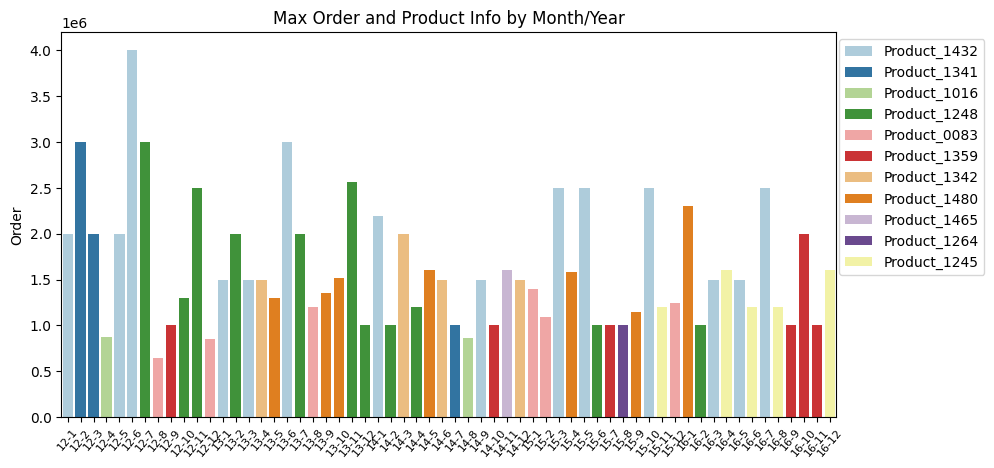

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x=[f"{str(ind[0])[2:]}-{ind[1]}" for ind in max_df.index],y='Order',hue='Product_Code',data=max_df,palette='Paired')
plt.xticks(rotation=50,fontsize=8)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.title("Max Order and Product Info by Month/Year");

In [ ]:
# df1.to_csv('/content/drive/MyDrive/forecasting_clean.csv')

Rewrite: warehouse is a proxy for customer location

In [ ]:
df1.groupby('Warehouse')['Order'].sum().sort_values(ascending=False)

,Order
Warehouse,
Whse_J,3.362743e+09
Whse_S,1.033122e+09
Whse_C,5.820042e+08
Whse_A,1.476466e+08


In [ ]:
df1['Warehouse'].value_counts()

,count
Warehouse,
Whse_J,764215
Whse_A,142197
Whse_S,88024
Whse_C,42207


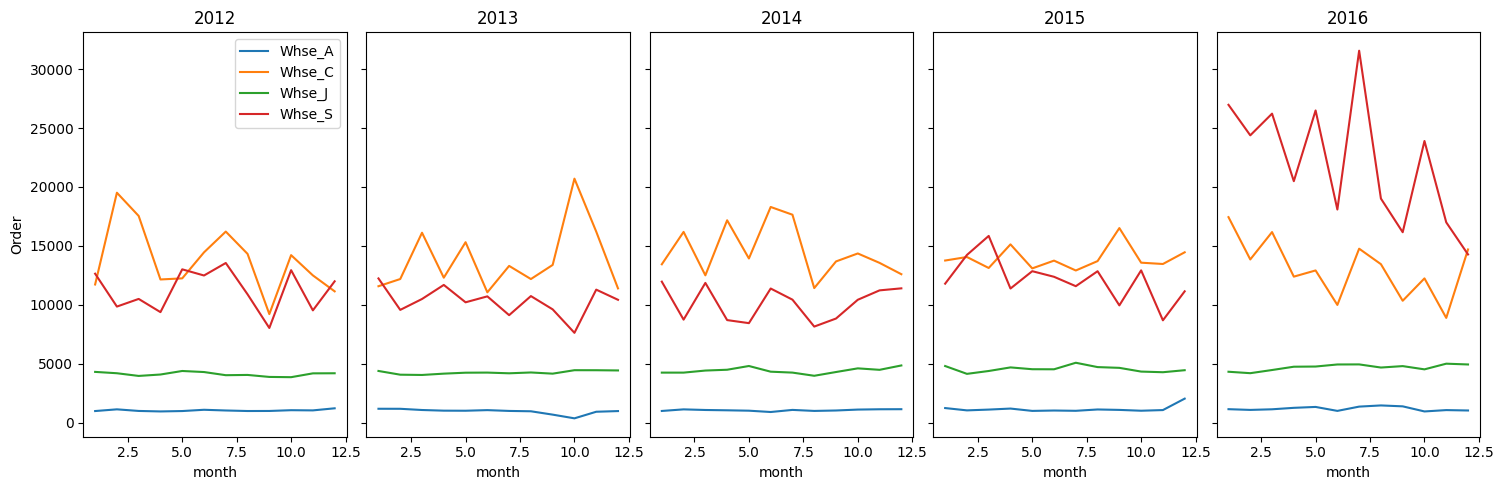

In [ ]:
# average orders per warehouse by time
fig, ax = plt.subplots(1,df1['year'].nunique(),figsize=(15,5),sharey=True)
df1['month'] = df1['month'].astype(object)
for i, yr in enumerate(df1['year'].unique()):
  boolean = True if i == 0 else False
  sns.lineplot(df1[df1['year']==yr].groupby(['month','Warehouse'])['Order'].mean().reset_index(),x='month',y='Order',hue='Warehouse',ax=ax[i])
  ax[i].set_title(yr)
  ax[i].legend().set_visible(boolean)
plt.tight_layout()

In [ ]:
# which products are best-seller in terms of average quantity per order count in each warehouse?
df1.groupby(['Warehouse','Product_Code']).apply(lambda x: x['Order'].mean()).rename('mean').reset_index().groupby('Warehouse').apply(lambda x: x.sort_values(by='mean',ascending=False)[["Product_Code","mean"]][:3])

Product_Code           mean
Warehouse                                  
Whse_A    178   Product_0990   22570.588235
          105   Product_0424   18614.457831
          204   Product_1154   11180.555556
Whse_C    566   Product_1245  289572.815534
          556   Product_1166  125299.401198
          604   Product_1480  102136.593592
Whse_J    1497  Product_1152  145422.077922
          1436  Product_1048   54062.500000
          1502  Product_1157   50520.673813
Whse_S    2311  Product_0083  469460.559796
          2667  Product_1432  139322.834646
          2312  Product_0084   99901.785714

In [ ]:
df1.groupby('Warehouse').apply(lambda x: x['Product_Code'].value_counts()[:3]).rename('best_counts')

Warehouse  Product_Code
Whse_A     Product_1496     3323
           Product_1470     3096
           Product_0200     2472
Whse_C     Product_0349     1148
           Product_2167     1026
           Product_0191      938
Whse_J     Product_1359    16935
           Product_1295    10575
           Product_1378     9770
Whse_S     Product_1341     1886
           Product_0033     1146
           Product_1431      935
Name: best_counts, dtype: int64